###  필요 라이브러리 Import

In [42]:
import os
import re
import string
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

### 데이터 경로 및 하이퍼 파라미터 설정

In [43]:
TRAIN_FILE = "data/train_data.txt"
TEST_FILE_SOLUTION = "data/test_data_solution.txt"

# 하이퍼파라미터
MAX_VOCAB_SIZE = 30000
MAX_SEQ_LEN = 256

EMBED_DIM = 128
HIDDEN_DIM = 128
NUM_LAYERS = 1
BIDIRECTIONAL = True
BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 5e-4  # 0.0005
DROPOUT_RATE = 0.4

### 데이터 로드 및 전처리

In [44]:
# train_data.txt는 " ::: " 기준으로 4컬럼 (id, title, genre, plot)
df_raw = pd.read_csv(
    TRAIN_FILE,
    sep=" ::: ",
    engine="python",
    header=None
)

print("Train raw shape:", df_raw.shape)

if df_raw.shape[1] == 4:
    df_raw.columns = ["id", "title", "genre", "plot"]
elif df_raw.shape[1] == 3:
    df_raw.columns = ["title", "genre", "plot"]
else:
    raise ValueError(f"Unexpected number of columns in train_data: {df_raw.shape[1]}")

# 제목 정리
def clean_title(t):
    return str(t).strip()

df_raw["title"] = df_raw["title"].apply(clean_title)
df_raw["text"] = df_raw["plot"].astype(str)

# 장르 파싱: 콤마나 | 둘 다 구분자로 처리
def parse_genres(g):
    if pd.isna(g):
        return []
    parts = re.split("[,|]", str(g))
    return [p.strip().lower() for p in parts if p.strip()]

df_raw["genre_list"] = df_raw["genre"].apply(parse_genres)

# 전체 장르 vocab
all_genres = sorted({g for lst in df_raw["genre_list"] for g in lst})
genre_to_idx = {g: i for i, g in enumerate(all_genres)}
idx_to_genre = {i: g for g, i in genre_to_idx.items()}
NUM_LABELS = len(genre_to_idx)

print("Number of genres:", NUM_LABELS)
print(all_genres)

# 🔹 single-label: 장르 리스트 → 대표 장르 하나의 인덱스
def genre_list_to_label_idx(genres):
    """
    Kaggle 데이터는 보통 장르가 1개지만,
    혹시 2개 이상이면 첫 번째 것만 사용 (single-label)
    """
    if not genres:
        return -1
    main = genres[0]
    return genre_to_idx.get(main, -1)

df_raw["label_idx"] = df_raw["genre_list"].apply(genre_list_to_label_idx)

# 유효한 라벨만 남기기
df = df_raw[df_raw["label_idx"] >= 0].reset_index(drop=True)
print("Filtered train shape:", df.shape)
df[["title", "genre", "genre_list", "label_idx"]].head()


Train raw shape: (54214, 4)
Number of genres: 27
['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'game-show', 'history', 'horror', 'music', 'musical', 'mystery', 'news', 'reality-tv', 'romance', 'sci-fi', 'short', 'sport', 'talk-show', 'thriller', 'war', 'western']
Filtered train shape: (54214, 7)


,title,genre,genre_list,label_idx
0,Oscar et la dame rose (2009),drama,[drama],8
1,Cupid (1997),thriller,[thriller],24
2,"Young, Wild and Wonderful (1980)",adult,[adult],1
3,The Secret Sin (1915),drama,[drama],8
4,The Unrecovered (2007),drama,[drama],8


### 텍스트 정제 & 토큰화, vocab 생성

In [45]:
def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"<br\s*/?>", " ", text)
    # 구두점 제거
    text = text.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)
df["tokens"] = df["clean_text"].str.split()

# vocab 생성
from collections import Counter

token_counter = Counter()
for tokens in df["tokens"]:
    token_counter.update(tokens)

# special tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

most_common = token_counter.most_common(MAX_VOCAB_SIZE - 2)
itos = [PAD_TOKEN, UNK_TOKEN] + [w for w, _ in most_common]
stoi = {w: i for i, w in enumerate(itos)}

PAD_IDX = stoi[PAD_TOKEN]
UNK_IDX = stoi[UNK_TOKEN]
VOCAB_SIZE = len(itos)

print("Vocab size:", VOCAB_SIZE)

def tokens_to_ids(tokens):
    return [stoi.get(t, UNK_IDX) for t in tokens]

def pad_or_truncate(ids, max_len=MAX_SEQ_LEN, pad_idx=PAD_IDX):
    if len(ids) >= max_len:
        return ids[:max_len]
    return ids + [pad_idx] * (max_len - len(ids))

df["input_ids"] = df["tokens"].apply(tokens_to_ids).apply(pad_or_truncate)

df[["clean_text", "tokens", "input_ids", "label_idx"]].head()


Vocab size: 30000


,clean_text,tokens,input_ids,label_idx
0,listening in to a conversation between his doc...,"[listening, in, to, a, conversation, between, ...","[5267, 7, 6, 4, 2025, 100, 9, 480, 3, 221, 648...",8
1,a brother and sister with a past incestuous re...,"[a, brother, and, sister, with, a, past, inces...","[4, 186, 3, 234, 11, 4, 166, 14032, 210, 44, 4...",24
2,as the bus empties the students for their fiel...,"[as, the, bus, empties, the, students, for, th...","[17, 2, 1664, 1, 2, 385, 14, 18, 1238, 410, 6,...",1
3,to help their unemployed father make ends meet...,"[to, help, their, unemployed, father, make, en...","[6, 122, 18, 2895, 69, 98, 560, 224, 6483, 3, ...",8
4,the film s title refers not only to the un rec...,"[the, film, s, title, refers, not, only, to, t...","[2, 38, 10, 985, 6101, 47, 61, 6, 2, 778, 5225...",8


### Dataset / DataLoader 정의

In [46]:
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=SEED,
    stratify=df["label_idx"]  # 🔹 single-label 기준 stratify
)

class MovieGenreDataset(Dataset):
    def __init__(self, df):
        self.inputs = df["input_ids"].tolist()
        self.labels = df["label_idx"].values.astype(np.int64)  # 정수 라벨

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = torch.tensor(self.inputs[idx], dtype=torch.long)
        y = torch.tensor(self.labels[idx], dtype=torch.long)   # CrossEntropy용 long
        return x, y

train_dataset = MovieGenreDataset(train_df)
val_dataset = MovieGenreDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataset), len(val_dataset)


(48792, 5422)

### LSTM 모델 정의

In [47]:
class LSTMTextClassifier(nn.Module):
    def __init__(self,
                 vocab_size,
                 embed_dim,
                 hidden_dim,
                 num_labels,
                 num_layers=1,
                 bidirectional=True,
                 pad_idx=0,
                 dropout=0.4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        lstm_output_dim = hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_output_dim, num_labels)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)       # (B, T, E)
        output, (h_n, c_n) = self.lstm(embedded)  # h_n: (num_layers * num_directions, B, H)

        if self.lstm.bidirectional:
            last_hidden = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            last_hidden = h_n[-1]

        last_hidden = self.dropout(last_hidden)
        logits = self.fc(last_hidden)             # (B, num_labels)
        return logits


model = LSTMTextClassifier(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_labels=NUM_LABELS,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    pad_idx=PAD_IDX,
    dropout=DROPOUT_RATE,
).to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    weight_decay=1e-5 # L2 정규화 강도
)

print(model)

LSTMTextClassifier(
  (embedding): Embedding(30000, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=27, bias=True)
)


### 학습 / 검증 루프

In [48]:
train_loss_history = []
val_loss_history = []
val_f1_history = []

patience = 3
min_delta = 1e-4

def train_one_epoch(epoch):
    model.train()
    total_loss = 0.0
    num_batches = len(train_loader)

    pbar = tqdm(enumerate(train_loader), total=num_batches)
    for batch_idx, (input_ids, labels) in pbar:
        input_ids = input_ids.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(input_ids)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        avg_loss_so_far = total_loss / (batch_idx + 1)

        pbar.set_description(f"Epoch {epoch}")
        pbar.set_postfix({
            "batch": f"{batch_idx+1}/{num_batches}",
            "loss": f"{loss.item():.4f}",
            "avg_loss": f"{avg_loss_so_far:.4f}",
        })

    avg_loss = total_loss / num_batches
    print(f"\n[Epoch {epoch}] Train loss: {avg_loss:.4f}")
    return avg_loss


def evaluate(loader=None, desc="Validating"):
    if loader is None:
        loader = val_loader

    model.eval()
    total_loss = 0.0
    all_true = []
    all_pred = []

    num_batches = len(loader)
    pbar = tqdm(enumerate(loader), total=num_batches)

    with torch.no_grad():
        for batch_idx, (input_ids, labels) in pbar:
            input_ids = input_ids.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(input_ids)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)

            all_true.append(labels.cpu().numpy())
            all_pred.append(preds.cpu().numpy())

            avg_loss_so_far = total_loss / (batch_idx + 1)
            pbar.set_description(desc)
            pbar.set_postfix({"avg_loss": f"{avg_loss_so_far:.4f}"})

    avg_loss = total_loss / num_batches
    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)

    f1_macro = f1_score(all_true, all_pred, average="macro", zero_division=0)

    print(f"\n{desc} loss: {avg_loss:.4f} | F1(macro): {f1_macro:.4f}")
    return avg_loss, f1_macro


best_val_loss = float("inf")
best_epoch = 0
best_weights = None
patience_counter = 0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(epoch)
    val_loss, val_f1 = evaluate()

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append(val_f1)

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_epoch = epoch
        best_weights = copy.deepcopy(model.state_dict())
        patience_counter = 0
        print(f"🔥 New best model at epoch {epoch}! val_loss={val_loss:.4f}, F1={val_f1:.4f}")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement in val_loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(
                f"⏹ Early stopping triggered at epoch {epoch}. "
                f"Best epoch = {best_epoch} (val_loss={best_val_loss:.4f})"
            )
            break

if best_weights is not None:
    model.load_state_dict(best_weights)
    print(f"✅ Loaded best model weights from epoch {best_epoch}")

Epoch 1: 100%|██████████████████████████| 763/763 [00:33<00:00, 22.73it/s, batch=763/763, loss=1.7338, avg_loss=2.2063]



[Epoch 1] Train loss: 2.2063


Validating: 100%|█████████████████████████████████████████████████████| 85/85 [00:01<00:00, 49.53it/s, avg_loss=2.0290]



Validating loss: 2.0290 | F1(macro): 0.0538
🔥 New best model at epoch 1! val_loss=2.0290, F1=0.0538


Epoch 2: 100%|██████████████████████████| 763/763 [00:27<00:00, 27.85it/s, batch=763/763, loss=2.2129, avg_loss=1.9696]



[Epoch 2] Train loss: 1.9696


Validating: 100%|█████████████████████████████████████████████████████| 85/85 [00:01<00:00, 48.82it/s, avg_loss=1.9092]



Validating loss: 1.9092 | F1(macro): 0.0611
🔥 New best model at epoch 2! val_loss=1.9092, F1=0.0611


Epoch 3: 100%|██████████████████████████| 763/763 [00:22<00:00, 33.95it/s, batch=763/763, loss=1.6214, avg_loss=1.8321]



[Epoch 3] Train loss: 1.8321


Validating: 100%|█████████████████████████████████████████████████████| 85/85 [00:00<00:00, 93.54it/s, avg_loss=1.8353]



Validating loss: 1.8353 | F1(macro): 0.0953
🔥 New best model at epoch 3! val_loss=1.8353, F1=0.0953


Epoch 4: 100%|██████████████████████████| 763/763 [00:16<00:00, 46.36it/s, batch=763/763, loss=1.3248, avg_loss=1.6986]



[Epoch 4] Train loss: 1.6986


Validating: 100%|█████████████████████████████████████████████████████| 85/85 [00:00<00:00, 93.81it/s, avg_loss=1.7340]



Validating loss: 1.7340 | F1(macro): 0.1160
🔥 New best model at epoch 4! val_loss=1.7340, F1=0.1160


Epoch 5: 100%|██████████████████████████| 763/763 [00:16<00:00, 45.76it/s, batch=763/763, loss=1.5498, avg_loss=1.5749]



[Epoch 5] Train loss: 1.5749


Validating: 100%|█████████████████████████████████████████████████████| 85/85 [00:00<00:00, 96.82it/s, avg_loss=1.6809]



Validating loss: 1.6809 | F1(macro): 0.1348
🔥 New best model at epoch 5! val_loss=1.6809, F1=0.1348


Epoch 6: 100%|██████████████████████████| 763/763 [00:17<00:00, 44.75it/s, batch=763/763, loss=1.4095, avg_loss=1.4516]



[Epoch 6] Train loss: 1.4516


Validating: 100%|█████████████████████████████████████████████████████| 85/85 [00:00<00:00, 93.83it/s, avg_loss=1.6651]



Validating loss: 1.6651 | F1(macro): 0.1556
🔥 New best model at epoch 6! val_loss=1.6651, F1=0.1556


Epoch 7: 100%|██████████████████████████| 763/763 [00:16<00:00, 45.23it/s, batch=763/763, loss=0.9404, avg_loss=1.3470]



[Epoch 7] Train loss: 1.3470


Validating: 100%|█████████████████████████████████████████████████████| 85/85 [00:00<00:00, 92.30it/s, avg_loss=1.7110]



Validating loss: 1.7110 | F1(macro): 0.1620
⚠️ No improvement in val_loss for 1 epoch(s).


Epoch 8: 100%|██████████████████████████| 763/763 [00:16<00:00, 45.12it/s, batch=763/763, loss=1.5119, avg_loss=1.2456]



[Epoch 8] Train loss: 1.2456


Validating: 100%|█████████████████████████████████████████████████████| 85/85 [00:00<00:00, 91.88it/s, avg_loss=1.6379]



Validating loss: 1.6379 | F1(macro): 0.1834
🔥 New best model at epoch 8! val_loss=1.6379, F1=0.1834


Epoch 9: 100%|██████████████████████████| 763/763 [00:17<00:00, 43.70it/s, batch=763/763, loss=1.2319, avg_loss=1.1438]



[Epoch 9] Train loss: 1.1438


Validating: 100%|█████████████████████████████████████████████████████| 85/85 [00:00<00:00, 92.28it/s, avg_loss=1.6715]



Validating loss: 1.6715 | F1(macro): 0.2062
⚠️ No improvement in val_loss for 1 epoch(s).


Epoch 10: 100%|█████████████████████████| 763/763 [00:16<00:00, 45.10it/s, batch=763/763, loss=1.0781, avg_loss=1.0419]



[Epoch 10] Train loss: 1.0419


Validating: 100%|█████████████████████████████████████████████████████| 85/85 [00:00<00:00, 93.84it/s, avg_loss=1.7878]


Validating loss: 1.7878 | F1(macro): 0.2171
⚠️ No improvement in val_loss for 2 epoch(s).
✅ Loaded best model weights from epoch 8


### 학습 곡선 시각화

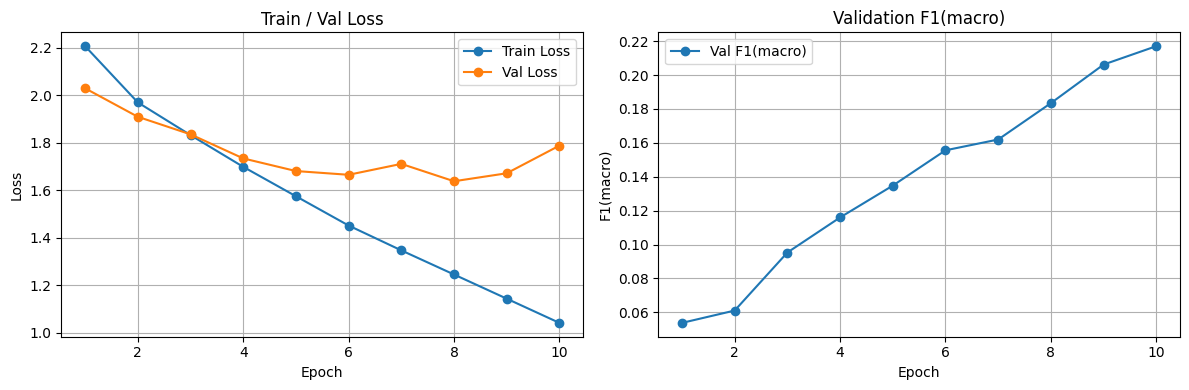

In [49]:
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, marker='o', label='Train Loss')
plt.plot(epochs, val_loss_history, marker='o', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train / Val Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_f1_history, marker='o', label='Val F1(macro)')
plt.xlabel("Epoch")
plt.ylabel("F1(macro)")
plt.title("Validation F1(macro)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 베스트 모델 저장

In [50]:
MODEL_DIR = "model"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, f"lstm_high.pt")

save_obj = {
    "epoch": best_epoch,
    "model_state_dict": model.state_dict(),
    "vocab": {
        "stoi": stoi,
        "itos": itos,
    },
    "genre_to_idx": genre_to_idx,
    "idx_to_genre": idx_to_genre,
    "config": {
        "embed_dim": EMBED_DIM,
        "hidden_dim": HIDDEN_DIM,
        "num_layers": NUM_LAYERS,
        "bidirectional": BIDIRECTIONAL,
        "num_labels": NUM_LABELS,
        "pad_idx": PAD_IDX,
        "max_seq_len": MAX_SEQ_LEN,
    },
}

torch.save(save_obj, MODEL_PATH)
print("✅ Saved best model to:", MODEL_PATH)


✅ Saved best model to: model\lstm_high.pt


## 정확도 측정
### test_data_solution.txt 로드

In [51]:
df_test_raw = pd.read_csv(
    TEST_FILE_SOLUTION,
    sep=" ::: ",
    engine="python",
    header=None
)

print("Test raw shape:", df_test_raw.shape)

if df_test_raw.shape[1] == 4:
    df_test_raw.columns = ["id", "title", "genre", "plot"]
elif df_test_raw.shape[1] == 3:
    df_test_raw.columns = ["title", "genre", "plot"]
else:
    raise ValueError(f"Unexpected number of columns in test_data_solution: {df_test_raw.shape[1]}")

df_test_raw["title"] = df_test_raw["title"].apply(clean_title)
df_test_raw["text"] = df_test_raw["title"].astype(str) + ". " + df_test_raw["plot"].astype(str)

df_test_raw["genre_list"] = df_test_raw["genre"].apply(parse_genres)
df_test_raw["label_idx"] = df_test_raw["genre_list"].apply(genre_list_to_label_idx)

df_test = df_test_raw[df_test_raw["label_idx"] >= 0].reset_index(drop=True)
print("Filtered test shape:", df_test.shape)

df_test["clean_text"] = df_test["text"].apply(clean_text)
df_test["tokens"] = df_test["clean_text"].str.split()
df_test["input_ids"] = df_test["tokens"].apply(tokens_to_ids).apply(pad_or_truncate)

df_test[["text", "genre_list", "label_idx"]].head()


Test raw shape: (54200, 4)
Filtered test shape: (54200, 7)


,text,genre_list,label_idx
0,Edgar's Lunch (1998). L.R. Brane loves his lif...,[thriller],24
1,"La guerra de papá (1977). Spain, March 1964: Q...",[comedy],5
2,Off the Beaten Track (2010). One year in the l...,[documentary],7
3,"Meu Amigo Hindu (2015). His father has died, h...",[drama],8
4,Er nu zhai (1955). Before he was known interna...,[drama],8


### Test Dataset / DataLoader 만들기

In [52]:
test_dataset = MovieGenreDataset(df_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(test_dataset)


54200

### 정확도 / F1 평가 함수

In [53]:
def evaluate_on_loader(loader, desc="Eval"):
    model.eval()
    total_loss = 0.0

    all_true = []
    all_pred = []

    num_batches = len(loader)
    pbar = tqdm(enumerate(loader), total=num_batches)

    with torch.no_grad():
        for batch_idx, (input_ids, labels) in pbar:
            input_ids = input_ids.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(input_ids)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)

            all_true.append(labels.cpu().numpy())
            all_pred.append(preds.cpu().numpy())

            avg_loss_so_far = total_loss / (batch_idx + 1)
            pbar.set_description(desc)
            pbar.set_postfix({"avg_loss": f"{avg_loss_so_far:.4f}"})

    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)

    avg_loss = total_loss / num_batches
    acc = accuracy_score(all_true, all_pred)
    f1_macro = f1_score(all_true, all_pred, average="macro", zero_division=0)
    f1_micro = f1_score(all_true, all_pred, average="micro", zero_division=0)

    print(
        f"[{desc}] loss: {avg_loss:.4f} | "
        f"Acc: {acc:.4f} | "
        f"F1_macro: {f1_macro:.4f} | "
        f"F1_micro: {f1_micro:.4f}"
    )

    return {
        "loss": avg_loss,
        "acc": acc,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
    }


### Test 데이터 정확도/F1 계산

In [54]:
test_metrics = evaluate_on_loader(test_loader, desc="Test")
print("\n🏁 Final Test metrics:", test_metrics)


Test: 100%|█████████████████████████████████████████████████████████| 847/847 [00:09<00:00, 89.08it/s, avg_loss=1.6593]


[Test] loss: 1.6593 | Acc: 0.5376 | F1_macro: 0.1847 | F1_micro: 0.5376

🏁 Final Test metrics: {'loss': 1.6593144880134916, 'acc': 0.5376383763837639, 'f1_macro': 0.18473985825662925, 'f1_micro': 0.5376383763837639}
